In [1]:
# Preamble
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from utils import load_results
preds, probs, actual = load_results()

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

probs.head()

Classifier,KNeighborsClassifier,RandomForestClassifier,LogisticRegression,SGDClassifier,LinearSVC,GaussianNB
0,1.0,1.0,0.979908,0.626272,0.627873,1.0
1,1.0,1.0,0.968832,0.631219,0.574250,1.0
2,1.0,1.0,0.972728,0.629980,0.578030,1.0
3,1.0,1.0,0.999986,0.747994,0.775335,1.0
4,1.0,1.0,0.815760,0.549328,0.574944,1.0


In [2]:
class KdeCalibration(object):
    
    def __init__(self, X_values, y_mask, label='', bins=100, kernel='gaussian', bandwidth=0.1):
        self.true = X_values[y_mask]
        self.total = X_values
        self.label = label
        self.kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
        self.x_axis = np.linspace(0, 1, bins)
        
    def __repr__(self):
        return f'{self.__class__.__name__}(label={self.label})'
    
    def score(self, name):
        vec = getattr(self, name)
        self.kde.fit(vec.reshape(-1, 1))
        scores = self.kde.score_samples(self.x_axis.reshape(-1, 1))
        scaled = np.exp(scores) * len(vec)
        setattr(self, f'{name}_scores_', scaled)
        return scaled
    
    def calibration_curve(self):
        if not hasattr(self, 'true_scores_'):
            self.score('true')
        if not hasattr(self, 'total_scores_'):
            self.score('total')
        return self.true_scores_ / self.total_scores_
    
    def plot_calibration(self, ax=None):
        cal_curve = self.calibration_curve()
        unit = (0, 1)
        
        if ax is None:
            ax = plt.gca()
        
        ax.set_ylim(unit)
        ax.set_ylim(unit)
        ax2 = ax.twinx()
        ax2.set_ylim((0, self.total_scores_.max()))
        ax.margins(x=0.1, y=0.1)
        ax2.margins(x=0.1, y=0.1)
        lines = []
        lines.extend(ax.plot(unit, unit, 'k:', label='Perfectly Calibrated'))
        lines.extend(ax.plot(self.x_axis, cal_curve, label='True / Total'))
        lines.extend(ax2.plot(self.x_axis, self.true_scores_, 'C1', alpha=0.5, label='True'))
        lines.extend(ax2.plot(self.x_axis, self.total_scores_, 'C2', alpha=0.5, label='Total'))         
        ax.legend(lines, [li.get_label() for li in lines])
        ax.set_title(f'{self.label} ({self.kde.bandwidth})')
        return ax

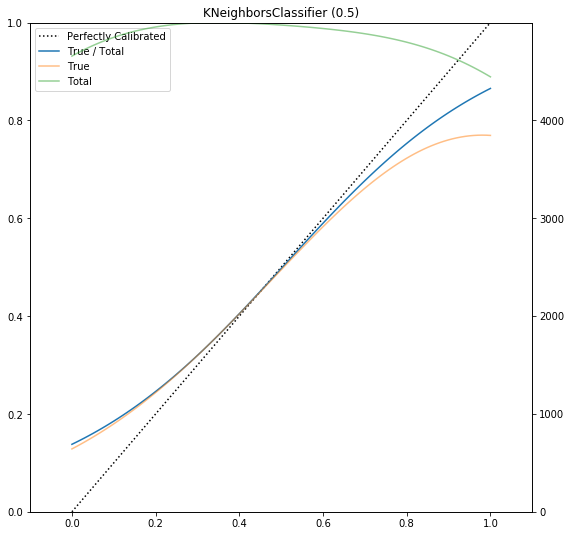

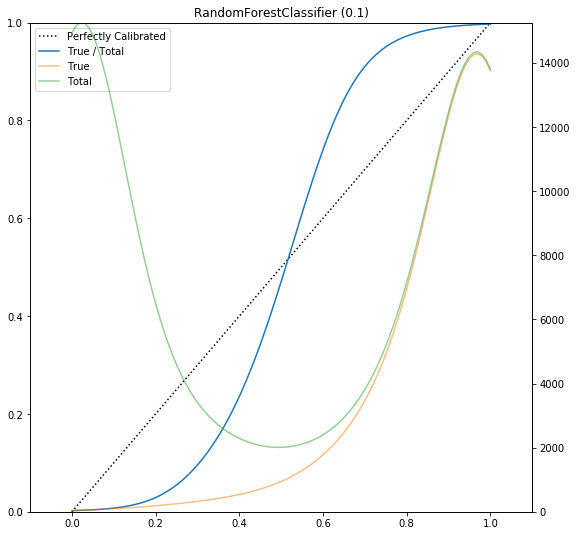

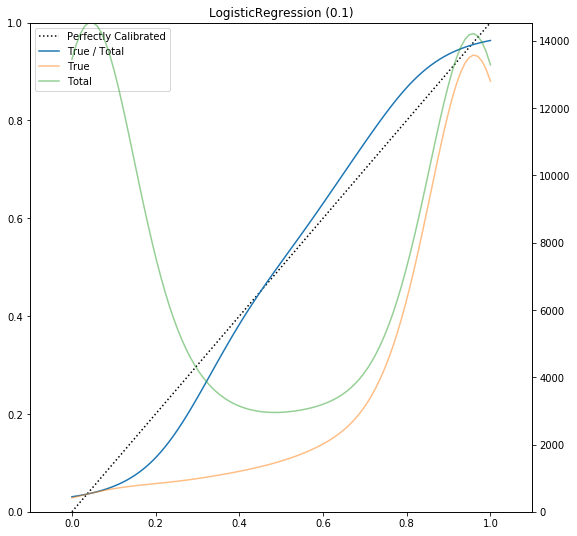

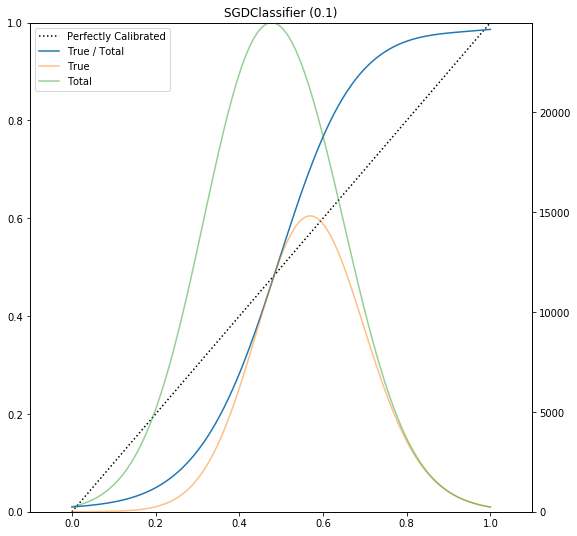

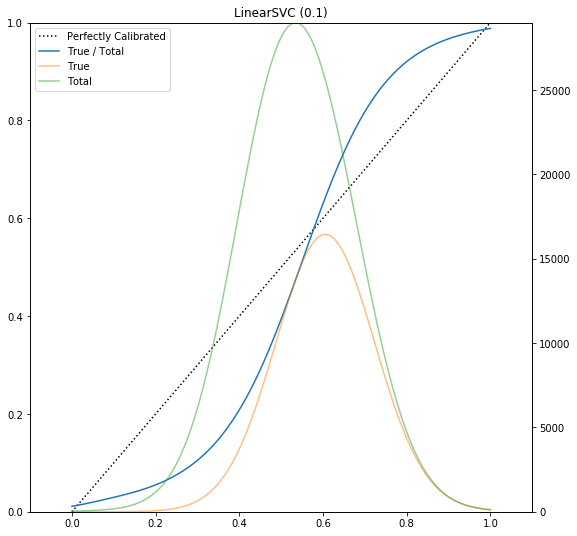

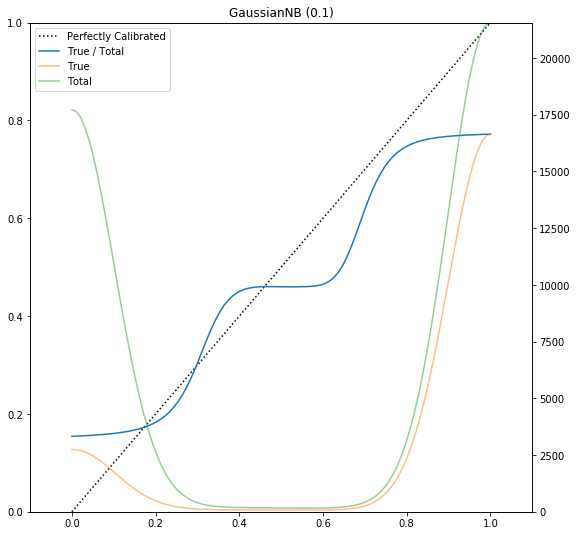

In [3]:
kdes = [KdeCalibration(prob_vec.values, actual, label=label, bandwidth=0.5 if label.startswith('KN') else 0.1)
        for label, prob_vec in probs.iteritems()]

for i, _est in enumerate(kdes):
    plt.figure(i, figsize=(9,9))
    _est.plot_calibration()
plt.show()